In [1]:
from patchify import patchify
from transformers import SamModel, SamProcessor, SamConfig
import torch
from datasets import Dataset
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import random
import time
import cv2
import json
import numpy as np
from tqdm import tqdm
import matplotlib.path as mpath

from utils import *

c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.

In [2]:
all_images_dir = r'data/short_range/sc_rgb/'
all_labels_dir = r'data/short_range/sc_rgb_labels_json/'
all_masks_dir =  r'data/short_range/sc_rgb_masks/'

dataset_split_dir = 'data/short_range/dataset_splits/split_75_5_20/'

checkpoints_dir = 'finetuned_sam_checkpoints/short_range'

In [3]:
def get_label(label_path: str):
    label_dict = json.loads(open(label_path, 'r').read())
    return label_dict

def generate_mask(label_dict: dict, image_dims: tuple):
    mask = np.zeros(image_dims)
    for label_i in label_dict['shapes']:
        points = label_i['points']
        
        x, y = np.mgrid[0:image_dims[0], 0:image_dims[1]]
        grid_points = np.vstack((y.ravel(), x.ravel())).T

        path = mpath.Path(points)

        inside = path.contains_points(grid_points)
        mask_i = inside.reshape(image_dims)
        
        mask[mask_i == 1] = 1
            
    return mask

def save_mask(mask: np.ndarray, mask_path: str):
    mask = mask * 255
    cv2.imwrite(mask_path, mask)

def get_mask(mask_path: str):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = mask / 255
    return mask

def get_datapoints(split: str, generate_masks = False):
    with open(dataset_split_dir + split + '_files.txt', 'r') as f:
        image_file_names = f.read().splitlines()
    f.close()
    
    images = {}
    masks  = {}
    
    for file_name in tqdm(image_file_names):
        image_num = int(file_name.split('-')[1].split('.')[0])
        image_path = all_images_dir + file_name
        label_path = all_labels_dir + file_name.replace('jpg', 'json')
        
        image = cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        images[image_num] = image
        
        image_dims = image.shape[:2]
        
        label_dict = get_label(label_path)
        if generate_masks:
            mask = generate_mask(label_dict, image_dims)
            save_mask(mask, all_masks_dir + file_name)
        else:
            mask = get_mask(all_masks_dir + file_name)
        masks[image_num] = mask
        
    return images, masks


# train_images, train_masks = get_datapoints('train', generate_masks = True)
# val_images, val_masks     = get_datapoints('val', generate_masks = True)
# test_images, test_masks   = get_datapoints('test', generate_masks = True)

train_images, train_masks = get_datapoints('train')
val_images, val_masks     = get_datapoints('val')
test_images, test_masks   = get_datapoints('test')

100%|██████████| 61/61 [00:03<00:00, 16.50it/s]


In [4]:
original_dims = (3840, 2160)
new_dims = (768, 512)
patch_size = 256

In [7]:
def resize_image(img_arr: np.ndarray, image_dims) -> np.ndarray:
    img = Image.fromarray(img_arr)
    img = img.resize(image_dims)
    return np.array(img)

def prepare_patched_datasets(patch_size: int, image_dims: tuple[int, int], train_only=False) -> tuple[Dataset, Dataset]:
    step = patch_size

    # Combine train and val images as train
    train_img_patches = []
    train_mask_patches = []
    
    val_img_patches = []
    val_mask_patches = []

    test_img_patches = []
    test_mask_patches = []

    # Process train images
    i = 0
    for key in tqdm(train_images):
        # Load and resize image
        img = train_images[key]
        resized_img = resize_image(img, image_dims)

        # Patchify image
        patches_img = patchify(resized_img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                train_img_patches.append(single_patch_img)
        
        # Load and resize mask
        mask = train_masks[key][:, :] / 255
        mask = resize_image(mask, image_dims)

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                train_mask_patches.append(single_patch_mask)
        
        i += 1

    if not train_only:
        # Process val images
        i = 0
        for key in tqdm(val_images):
            # Load and resize image
            img = val_images[key]
            resized_img = resize_image(img, image_dims)

            # Patchify image
            patches_img = patchify(resized_img, (patch_size, patch_size, 3), step=step)
            for j in range(patches_img.shape[0]):
                for k in range(patches_img.shape[1]):
                    single_patch_img = patches_img[j,k,:,:][0]
                    val_img_patches.append(single_patch_img)

            # Load and resize mask
            mask = val_masks[key][:, :] / 255
            mask = resize_image(mask, image_dims)

            # Patchify mask
            patches_mask = patchify(mask, (patch_size, patch_size), step=step)
            for j in range(patches_mask.shape[0]):
                for k in range(patches_mask.shape[1]):
                    single_patch_mask = patches_mask[j,k,:,:]
                    val_mask_patches.append(single_patch_mask)
            
            i += 1

        # Process test images
        i = 0
        for key in tqdm(test_images):
            # Load and resize image
            img = test_images[key]
            resized_img = resize_image(img, image_dims)

            # Patchify image
            patches_img = patchify(resized_img, (patch_size, patch_size, 3), step=step)
            for j in range(patches_img.shape[0]):
                for k in range(patches_img.shape[1]):
                    single_patch_img = patches_img[j,k,:,:][0]
                    test_img_patches.append(single_patch_img)

            # Load and resize mask
            mask = test_masks[key][:, :] / 255
            mask = resize_image(mask, image_dims)

            # Patchify mask
            patches_mask = patchify(mask, (patch_size, patch_size), step=step)
            for j in range(patches_mask.shape[0]):
                for k in range(patches_mask.shape[1]):
                    single_patch_mask = patches_mask[j,k,:,:]
                    test_mask_patches.append(single_patch_mask)
            
            i += 1 
            
        X_val = np.array(val_img_patches)
        Y_val = np.array(val_mask_patches)

        X_test = np.array(test_img_patches)
        Y_test = np.array(test_mask_patches)
        
        valid_indices = [i for i, mask in enumerate(Y_val) if mask.max() != 0]
        num_valid = len(valid_indices)
        count = 0
        for i, mask in enumerate(Y_val):
            if mask.max() == 0 and count < num_valid:
                count += 1
                new_mask = np.zeros_like(mask)
                new_mask[0,0] = 1
                Y_val[i] = new_mask
                valid_indices.append(i)
        X_val = X_val[valid_indices]
        Y_val = Y_val[valid_indices]
        print("X_val shape:", X_val.shape)
        print("Y_val shape:", Y_val.shape)
        
        valid_indices = [i for i, mask in enumerate(Y_test) if mask.max() != 0]
        num_valid = len(valid_indices)
        count = 0
        for i, mask in enumerate(Y_test):
            if mask.max() == 0 and count < num_valid:
                count += 1
                new_mask = np.zeros_like(mask)
                new_mask[0,0] = 1
                Y_test[i] = new_mask
                valid_indices.append(i)
        X_test = X_test[valid_indices]
        Y_test = Y_test[valid_indices]
        print("X_test shape:", X_test.shape)
        print("Y_test shape:", Y_test.shape)
    
    X_train = np.array(train_img_patches)
    Y_train = np.array(train_mask_patches)
    valid_indices = [i for i, mask in enumerate(Y_train) if mask.max() != 0]
    num_valid = len(valid_indices)
    count = 0
    for i, mask in enumerate(Y_train):
        if mask.max() == 0 and count < num_valid:
            count += 1
            new_mask = np.zeros_like(mask)
            new_mask[0,0] = 1
            Y_train[i] = new_mask
            valid_indices.append(i)
    X_train = X_train[valid_indices]
    Y_train = Y_train[valid_indices]
    print("X_train shape:", X_train.shape)
    print("Y_train shape:", Y_train.shape)
    
    train_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_train],
        "mask":  [Image.fromarray(mask) for mask in Y_train],
    }
    
    train_dataset = Dataset.from_dict(train_dict)
    
    if not train_only:
        val_dict = {
            "image": [Image.fromarray(img.astype('uint8')) for img in X_val],
            "mask":  [Image.fromarray(mask) for mask in Y_val],
        }
        test_dict = {
            "image": [Image.fromarray(img.astype('uint8')) for img in X_test],
            "mask":  [Image.fromarray(mask) for mask in Y_test],
        }

        val_dataset  = Dataset.from_dict(val_dict)
        test_dataset  = Dataset.from_dict(test_dict)
    else:
        val_dataset = None
        test_dataset = None
    
    return train_dataset, val_dataset, test_dataset

# Get bounding boxes from mask. (FROM ONLINE SOURCE)
def get_bounding_box(ground_truth_map: np.ndarray) -> list[int]:
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [8]:
train_patch_dataset, _, _ = prepare_patched_datasets(patch_size, new_dims, train_only=True)

100%|██████████| 226/226 [00:31<00:00,  7.29it/s]


X_train shape: (1356, 256, 256, 3)
Y_train shape: (1356, 256, 256)


In [9]:
train_patch_dataset

Dataset({
    features: ['image', 'mask'],
    num_rows: 1356
})

In [10]:
# train_dict = {
#     'image': [Image.fromarray(img.astype('uint8')) for img in train_images.values()],
#     'mask': [Image.fromarray(mask.astype('uint8')) for mask in train_masks.values()],
# }
# val_dict = {
#     'image': [Image.fromarray(img.astype('uint8')) for img in val_images.values()],
#     'mask': [Image.fromarray(mask.astype('uint8')) for mask in val_masks.values()],
# }
test_dict = {
    'image': [Image.fromarray(img.astype('uint8')) for img in tqdm(test_images.values())],
    'mask': [Image.fromarray(mask.astype('uint8')) for mask in tqdm(test_masks.values())],
}

# train_dataset = Dataset.from_dict(train_dict)
# val_dataset   = Dataset.from_dict(val_dict)
test_dataset  = Dataset.from_dict(test_dict)

100%|██████████| 61/61 [00:00<00:00, 247.53it/s]


In [11]:
del train_images, train_masks, val_images, val_masks, test_images, test_masks

In [12]:
test_dataset

Dataset({
    features: ['image', 'mask'],
    num_rows: 61
})

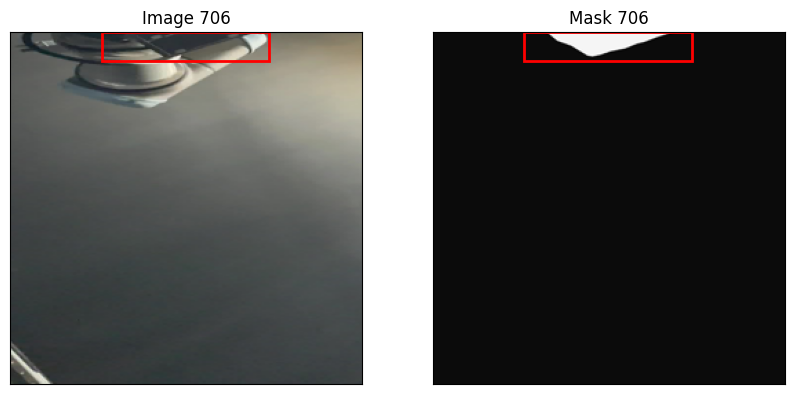

In [13]:
img_num = random.randint(0, len(train_patch_dataset)-1)
example_image = train_patch_dataset[img_num]["image"]
example_mask = np.array(train_patch_dataset[img_num]["mask"]) * 255

bbox = get_bounding_box(np.array(example_mask))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the iamge on left
axes[0].imshow(np.array(example_image), cmap='gray')
axes[0].set_title(f"Image {img_num}")

# Plot the mask on right
axes[1].imshow(example_mask, cmap='gray')
axes[1].set_title(f"Mask {img_num}")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    rect_pred = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
    # rect_true = Rectangle((example_bbox[0], example_bbox[1]), example_bbox[2], example_bbox[3], linewidth=2, edgecolor='g', facecolor='none')
    
    ax.add_patch(rect_pred)
    # ax.add_patch(rect_true)

plt.show()

In [14]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    """
    Used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        
        ground_truth_mask = np.array(item["mask"])

        # Get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)
        # prompt = [0, 0, 256, 256]

        # Prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # Add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [15]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
train_sam_dataset = SAMDataset(dataset=train_patch_dataset, processor=processor)
# val_sam_dataset = SAMDataset(dataset=val_patch_dataset, processor=processor)
# test_sam_dataset = SAMDataset(dataset=test_patch_dataset, processor=processor)

In [16]:
example = train_sam_dataset[0]
for k,v in example.items():
    print(k,v.shape)
    
example['pixel_values'].max()

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


tensor(1.7860)

In [17]:
from torch.utils.data import DataLoader

batch_size = 2

train_dataloader = DataLoader(train_sam_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
# val_dataloader = DataLoader(val_sam_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
# test_dataloader = DataLoader(test_sam_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [18]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)
    
batch["ground_truth_mask"].max()

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


tensor(1.)

In [19]:
def get_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

In [20]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from torch.optim import Adam
import monai

model = SamModel.from_pretrained("facebook/sam-vit-base")

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

device = get_device()
torch.cuda.empty_cache()

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder") or name.startswith("image_encoder"):
        param.requires_grad_(False)
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [21]:
def prepare_image(image: np.ndarray, dims: tuple[int, int], verbose=True) -> torch.Tensor:
    start_time = time.time()
    
    image = resize_image(image, dims)
    patches = patchify(np.array(image), (patch_size, patch_size, 3), step=256)
    patches = np.squeeze(patches)
    
    end_time = time.time()
    
    if verbose:
        print(f"Time taken to prepare image: {end_time - start_time:.2f} seconds")
    
    return patches

def compute_loss(model, inputs):
    outputs = model(pixel_values=inputs["pixel_values"].to(device),
                    input_boxes=inputs["input_boxes"].to(device),
                    multimask_output=False)

    # compute loss
    predicted_masks = outputs.pred_masks.squeeze(1)
    ground_truth_masks = inputs["ground_truth_mask"].float().to(device)
    loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

    return (loss, outputs)


def compute_losses(model, dataloader):
    losses = []
    for batch in tqdm(dataloader):
        loss, _ = compute_loss(model, batch)
        losses.append(loss)
    return losses


def save_checkpoint(model, optimizer, val_metrics, tr_metrics, epoch, path):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "tr_metrics": tr_metrics,
        "val_metrics": val_metrics,
    }
    try:
        torch.save(checkpoint, path)
        print(f"Checkpoint saved at {path}")
    except Exception as e:
        print(f"Error saving checkpoint: {e}")
        
def load_checkpoint(path):
    try:
        checkpoint = torch.load(path)
        print(f"Checkpoint loaded from {path}")
        return checkpoint
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        return None

In [22]:
num_epochs = 15

tr_metrics = {}
val_metrics = {}

for epoch in range(1, num_epochs+1):
    model.train()
    print(f'EPOCH: {epoch}')
    tr_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        loss, outputs = compute_loss(model, batch)

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        
        tr_losses.append(loss.item())
    
    # Print loss
    tr_metrics[epoch] = {'loss': round(np.mean(tr_losses), 5)}
    print(f'\tTraining metrics: {tr_metrics[epoch]}')
    
    # Save checkpoint
    save_checkpoint(model, optimizer, val_metrics, tr_metrics, epoch, f'{checkpoints_dir}/epoch_{epoch}.pt')
    
    print()

EPOCH: 1


  0%|          | 0/678 [00:00<?, ?it/s]

100%|██████████| 678/678 [03:03<00:00,  3.70it/s]


	Training metrics: {'loss': 0.44039}
Checkpoint saved at finetuned_sam_checkpoints/short_range/epoch_1.pt

EPOCH: 2


100%|██████████| 678/678 [03:04<00:00,  3.68it/s]


	Training metrics: {'loss': 0.13472}
Checkpoint saved at finetuned_sam_checkpoints/short_range/epoch_2.pt

EPOCH: 3


100%|██████████| 678/678 [03:05<00:00,  3.66it/s]


	Training metrics: {'loss': 0.09156}
Checkpoint saved at finetuned_sam_checkpoints/short_range/epoch_3.pt

EPOCH: 4


100%|██████████| 678/678 [03:05<00:00,  3.66it/s]


	Training metrics: {'loss': 0.08015}
Checkpoint saved at finetuned_sam_checkpoints/short_range/epoch_4.pt

EPOCH: 5


100%|██████████| 678/678 [03:05<00:00,  3.66it/s]


	Training metrics: {'loss': 0.07053}
Checkpoint saved at finetuned_sam_checkpoints/short_range/epoch_5.pt

EPOCH: 6


100%|██████████| 678/678 [03:04<00:00,  3.67it/s]


	Training metrics: {'loss': 0.06897}
Checkpoint saved at finetuned_sam_checkpoints/short_range/epoch_6.pt

EPOCH: 7


100%|██████████| 678/678 [03:04<00:00,  3.66it/s]


	Training metrics: {'loss': 0.05973}
Checkpoint saved at finetuned_sam_checkpoints/short_range/epoch_7.pt

EPOCH: 8


100%|██████████| 678/678 [03:04<00:00,  3.67it/s]


	Training metrics: {'loss': 0.05785}
Checkpoint saved at finetuned_sam_checkpoints/short_range/epoch_8.pt

EPOCH: 9


100%|██████████| 678/678 [03:04<00:00,  3.67it/s]


	Training metrics: {'loss': 0.05638}
Checkpoint saved at finetuned_sam_checkpoints/short_range/epoch_9.pt

EPOCH: 10


100%|██████████| 678/678 [03:04<00:00,  3.67it/s]


	Training metrics: {'loss': 0.05073}
Checkpoint saved at finetuned_sam_checkpoints/short_range/epoch_10.pt

EPOCH: 11


100%|██████████| 678/678 [03:04<00:00,  3.68it/s]


	Training metrics: {'loss': 0.0478}
Checkpoint saved at finetuned_sam_checkpoints/short_range/epoch_11.pt

EPOCH: 12


100%|██████████| 678/678 [03:04<00:00,  3.67it/s]


	Training metrics: {'loss': 0.04899}
Checkpoint saved at finetuned_sam_checkpoints/short_range/epoch_12.pt

EPOCH: 13


100%|██████████| 678/678 [03:04<00:00,  3.67it/s]


	Training metrics: {'loss': 0.04473}
Checkpoint saved at finetuned_sam_checkpoints/short_range/epoch_13.pt

EPOCH: 14


100%|██████████| 678/678 [03:04<00:00,  3.67it/s]


	Training metrics: {'loss': 0.04184}
Checkpoint saved at finetuned_sam_checkpoints/short_range/epoch_14.pt

EPOCH: 15


100%|██████████| 678/678 [03:04<00:00,  3.68it/s]


	Training metrics: {'loss': 0.04105}
Checkpoint saved at finetuned_sam_checkpoints/short_range/epoch_15.pt



In [27]:
def load_model_and_processor(model_path) -> tuple[SamModel, SamProcessor]:
    # Load the model configuration
    model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    print(model_path)
    # Create an instance of the model architecture with the loaded configuration
    model = SamModel(config=model_config)
    # Update the model by loading the weights from saved file.
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, processor

In [28]:
def has_satellite(image, vit_classifier, vit_feature_extractor):
    image_tensor = vit_feature_extractor(images=image, return_tensors="pt")["pixel_values"].to(get_device())
    logits = vit_classifier(image_tensor).logits
    prediction = logits.argmax(axis=-1)
    return bool(prediction == 1)

def resize_image(img_arr: np.ndarray, image_dims) -> np.ndarray:
    img = Image.fromarray(img_arr)
    img = img.resize(image_dims[::-1])
    return np.array(img)

def prepare_image(image: np.ndarray, dims: tuple[int, int], patch_size: int, verbose=True) -> torch.Tensor:
    start_time = time.time()
    
    image = resize_image(image, dims)
    patches = patchify(np.array(image), (patch_size, patch_size, 3), step=256)
    patches = np.squeeze(patches)
    
    end_time = time.time()
    
    if verbose:
        print(f"Time taken to prepare image: {end_time - start_time:.2f} seconds")
    
    return patches

def calculate_distance_with_all_neighbors(contours_info):
    coords = []
    for contour_info in contours_info:
        bbox = contour_info['bounding_box']
        x, y, w, h = bbox['x'], bbox['y'], bbox['width'], bbox['height']
        x_mid = x + w // 2
        y_mid = y + h // 2
        coords.append((x_mid, y_mid))

    tot_dist = 0
    num_dists = 0
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            x1, y1 = coords[i]
            x2, y2 = coords[j]
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            tot_dist += dist
            num_dists += 1
    
    if num_dists == 0: return 1
    return tot_dist**2


def mask_within_bbox(mask, bbox: tuple[tuple[int, int], int, int], thresh: float = 0.5) -> bool:
    mask_img = np.array(mask, dtype=np.uint8)
    tot_area = np.sum(mask_img)
    
    x, y, w, h = bbox
    
    area_in_bbox = 0
    for dw in range(w):
        for dh in range(h):
            if mask_img[y + dh, x + dw] == 1:
                area_in_bbox += 1

    return area_in_bbox / tot_area >= thresh, area_in_bbox / tot_area


def joint_intersection(mask1, mask2, thresh) -> bool:
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    if union.sum() == 0:
        return True, 0
    return np.sum(intersection) / np.sum(union) >= thresh, np.sum(intersection) / np.sum(union)


def predict(model: SamModel, processor: SamProcessor, device: torch.device, image: torch.Tensor, dims: tuple[int, int], thresh: float = 0.6, verbose=True):
        original_dims = image.shape[:-1]
        
        start_time = time.time()
        model.eval()
        
        patches = prepare_image(image, dims, patch_size=patch_size, verbose=verbose)
        prob_patches = []
        orig_patches = []
        
        fig, axs1 = plt.subplots(patches.shape[0], patches.shape[1], figsize=(10, 10))
        fig, axs2 = plt.subplots(patches.shape[0], patches.shape[1], figsize=(10, 10))
        
        for i, row_patches in enumerate(patches):
            prob_patches.append([])
            orig_patches.append([])
            for j, patch in enumerate(row_patches):

                inputs = processor(patch, return_tensors="pt")
                inputs = {k:v.to(device) for k,v in inputs.items()}
                
                with torch.no_grad():
                    outputs = model(**inputs, multimask_output=False)
                single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
                single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
                
                orig_patches[-1].append(single_patch_prob)
                
                axs1[i, j].imshow(single_patch_prob)
                axs1[i, j].axis('off')  # Hide axes
                
                single_patch_prob = single_patch_prob / np.sum(single_patch_prob)
                
                # Gaussian blur
                single_patch_prob = cv2.GaussianBlur(single_patch_prob, (7, 7), 0)
                
                axs2[i, j].imshow(single_patch_prob)
                axs2[i, j].axis('off')  # Hide axes
                
                prob_patches[-1].append(single_patch_prob)
        
        prob_patches = np.array(prob_patches)
        orig_patches = np.array(orig_patches)
        
        patch_contour_dists = []
        patch_contour_counts = []
        patch_contour_bboxes = []
        patch_contour_areas = []
        
        if verbose: 
            fig, axs = plt.subplots(patches.shape[0], patches.shape[1], figsize=(10, 10))
        
        for i in range(prob_patches.shape[0]):
            patch_contour_dists.append([])
            patch_contour_counts.append([])
            patch_contour_bboxes.append([])
            patch_contour_areas.append([])
            
            for j in range(prob_patches.shape[1]):
                patch = prob_patches[i][j]
                tot_dist_factor = patch.max()
                patch = patch / patch.max() * 255
                
                patch = patch.astype(np.uint8)
                patch = np.stack((patch, patch, patch), axis=2)
                imgray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
                ret, t = cv2.threshold(imgray, 127, 255, 0)
                contours, hierarchy = cv2.findContours(t, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                contours_info = []
                for contour in contours:
                    area = cv2.contourArea(contour)
                    perimeter = cv2.arcLength(contour, True)
                    x, y, w, h = cv2.boundingRect(contour)
                    contours_info.append({
                        'area': area,
                        'perimeter': perimeter,
                        'bounding_box': {'x': x, 'y': y, 'width': w, 'height': h}
                    })
                    
                tot_dist = calculate_distance_with_all_neighbors(contours_info)

                tot_dist = tot_dist / (tot_dist_factor**2)
                print("tot_dist", tot_dist)
                
                patch_contour_dists[-1].append(tot_dist)
                patch_contour_counts[-1].append(len(contours))
                patch_contour_bboxes[-1].append([i['bounding_box'] for i in contours_info])
                patch_contour_areas[-1].append(sum([i['area'] for i in contours_info]))
                
                if verbose: 
                    cv2.drawContours(patch, contours, -1, (0, 255, 0), 3)
                    axs[i, j].imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
                    axs[i, j].axis('off')  # Hide axes
        
        fig, axs3 = plt.subplots(patches.shape[0], patches.shape[1], figsize=(10, 10))
        
        patch_contour_counts = np.array(patch_contour_counts)
        patch_contour_areas = np.array(patch_contour_areas)
        patch_contour_dists = np.array(patch_contour_dists)
        dists_sum = sum([1/d for d in patch_contour_dists.flatten()])

        prob = None
        orig_prob = None
        for i in range(prob_patches.shape[0]):
            row_prob = None
            orig_row_prob = None
            for j in range(prob_patches.shape[1]):
                single_patch_prob = prob_patches[i][j]
                
                contour_mask = np.zeros(single_patch_prob.shape)
                for bbox in patch_contour_bboxes[i][j]:
                    x, y, w, h = bbox['x'], bbox['y'], bbox['width'], bbox['height']
                    
                    contour_mask[y:y+h, x:x+w] = True
                
                single_patch_prob = np.where(contour_mask, single_patch_prob, 0)
                
                contour_factor = 1
                contour_factor = 1/(patch_contour_dists[i][j] * dists_sum)
                if patch_contour_counts[i][j] == 0 or patch_contour_areas[i][j] <= 1:
                    pass
                else:
                    contour_factor /= patch_contour_counts[i][j]
                
                if verbose: print("contour_factor", contour_factor)
                single_patch_prob = single_patch_prob * (contour_factor)
                
                axs3[i, j].imshow(single_patch_prob)
                axs3[i, j].axis('off')  # Hide axes
                axs3[i, j].set_title(f"c_patch: {round(contour_factor, 2)}")
                
                if row_prob is None:
                    row_prob = single_patch_prob
                else:
                    row_prob = np.concatenate((row_prob, single_patch_prob), axis=1)
                
                if orig_row_prob is None:
                    orig_row_prob = orig_patches[i][j]
                else:
                    orig_row_prob = np.concatenate((orig_row_prob, orig_patches[i][j]), axis=1)
                    
            if prob is None:
                prob = row_prob
            else:
                prob = np.concatenate((prob, row_prob), axis=0)
            
            if orig_prob is None:
                orig_prob = orig_row_prob
            else:
                orig_prob = np.concatenate((orig_prob, orig_row_prob), axis=0)
        
        
        pred = (prob > prob.max() * thresh).astype(np.uint8)
        
        pred = resize_image(pred, original_dims)
        # prob = resize_image(prob, original_dims[1], original_dims[0])
        orig_prob = resize_image(orig_prob, original_dims)
        
        end_time = time.time()
        if verbose:
            print(f"Time taken to predict: {end_time - start_time:.2f} seconds")
        
        return pred, orig_prob


def plot_prediction(image: np.ndarray, prediction: np.ndarray, probability: np.ndarray, idx: int, bbox: tuple = None) -> None:
    if bbox:
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    else:
        fix, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first image on the left
    axes[0].imshow(np.array(image), cmap='gray')  # Assuming the first image is grayscale
    axes[0].set_title(idx)

    # Plot the second image on the right
    axes[1].imshow(probability)  # Assuming the second image is grayscale
    axes[1].set_title("Probability Map")

    # Plot the second image on the right
    axes[2].imshow(prediction, cmap='gray')  # Assuming the second image is grayscale
    axes[2].set_title("Prediction")
    
    if bbox:
        axes[3].imshow(prediction, cmap='gray') 
        axes[3].set_title("Prediction with bbox")
        
        x, y, w, h = bbox
        r = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axes[3].add_patch(r)

    # Hide axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Display the images side by side
    plt.show()
    
def sample_prediction(model, processor, device, dataset: Dataset, new_dims, thresh: float = 0.6, idx: int = None, verbose=False, iou_or_bbox: str = 'iou'):
        idx = random.randint(0, len(dataset)-1) if not idx else idx
        
        item = dataset[idx]
        image = np.array(item['image'])
        mask_true = np.array(item['mask'])
        bbox = get_bounding_box(mask_true)

        mask_pred, mask_prob = predict(model, processor, device, image, new_dims, thresh, verbose=verbose)

        within, ratio = False, 0
        # if iou_or_bbox == 'bbox':
        #     within, ratio = mask_within_bbox(mask_pred, bbox)
        # elif iou_or_bbox == 'iou':
        #     within, ratio = joint_intersection(mask_pred, mask_true, 0.5)
            
        # print("IoU:", ratio)
        # if within:
        #     print("Correctly segmented!")
        # else:
        #     print("Incorrectly segmented.")

        plot_prediction(image, mask_pred, mask_prob, idx, bbox)
        
        return mask_pred, mask_prob
    
def calc_accuracy(model: SamModel, processor: SamProcessor, dataset, image_size: int, thresh: float = 0.5):
    device = get_device()
    model.to(device)

    accuracies = []
    ratios = []
    for idx in tqdm(range(len(dataset))):
        item = dataset[idx]
        image = np.array(item['image'])
        mask_true = np.array(item['mask'])
        bbox = get_bounding_box(mask_true)
        
        mask_pred, _ = predict(model, processor, device, image, (image_size, image_size), thresh, verbose=False)
        
        if bbox is None:
            if mask_pred.max() == 0:
                accuracies.append(1)
            else:
                accuracies.append(0)
            continue

        
        # within, ratio = mask_within_bbox2(mask_pred, bbox)
        within, ratio = joint_intersection(mask_pred, mask_true, 0.5)
        ratios.append(ratio)
        if within:
            accuracies.append(1)
        else:
            accuracies.append(0)
 
    return np.mean(accuracies), ratios

In [29]:
pattern = os.path.join(checkpoints_dir, '*.pt')
file_list = glob.glob(pattern)

sam_model_paths = {}
for file_path in file_list:
    file_path = file_path.replace('\\', '/')
    epoch_num = int(file_path.split('_')[-1][:-3])
    sam_model_paths[epoch_num] = file_path
sam_model_paths = {k: v for (k, v) in sorted(sam_model_paths.items(), key=lambda x: x[0])}
sam_model_paths

{1: 'finetuned_sam_checkpoints/short_range/epoch_1.pt',
 2: 'finetuned_sam_checkpoints/short_range/epoch_2.pt',
 3: 'finetuned_sam_checkpoints/short_range/epoch_3.pt',
 4: 'finetuned_sam_checkpoints/short_range/epoch_4.pt',
 5: 'finetuned_sam_checkpoints/short_range/epoch_5.pt',
 6: 'finetuned_sam_checkpoints/short_range/epoch_6.pt',
 7: 'finetuned_sam_checkpoints/short_range/epoch_7.pt',
 8: 'finetuned_sam_checkpoints/short_range/epoch_8.pt',
 9: 'finetuned_sam_checkpoints/short_range/epoch_9.pt',
 10: 'finetuned_sam_checkpoints/short_range/epoch_10.pt',
 11: 'finetuned_sam_checkpoints/short_range/epoch_11.pt',
 12: 'finetuned_sam_checkpoints/short_range/epoch_12.pt',
 13: 'finetuned_sam_checkpoints/short_range/epoch_13.pt',
 14: 'finetuned_sam_checkpoints/short_range/epoch_14.pt',
 15: 'finetuned_sam_checkpoints/short_range/epoch_15.pt'}

In [31]:
model_loaded, processor = load_model_and_processor(sam_model_paths[10])
model_loaded.to(get_device())

finetuned_sam_checkpoints/short_range/epoch_10.pt


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

Time taken to prepare image: 0.05 seconds
tot_dist 4.4032608639454874e+17
tot_dist 2.1488400273092713e+20
tot_dist 1.1220374615494808e+19
tot_dist 1.2119435499112235e+17
tot_dist 2473764728555735.0
tot_dist 3.0635269711786144e+17
contour_factor 0.00023615345864471223
contour_factor 1.2941780373104057e-07
contour_factor 4.4406645487375305e-06
contour_factor 0.0012333722915287295
contour_factor 0.24170084989936275
contour_factor 0.0004337129088778179
Time taken to predict: 1.06 seconds


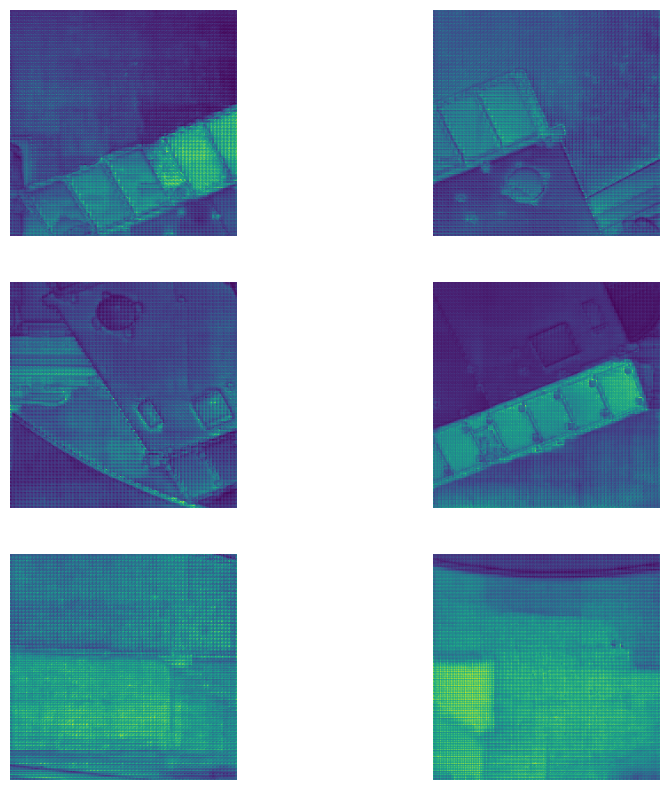

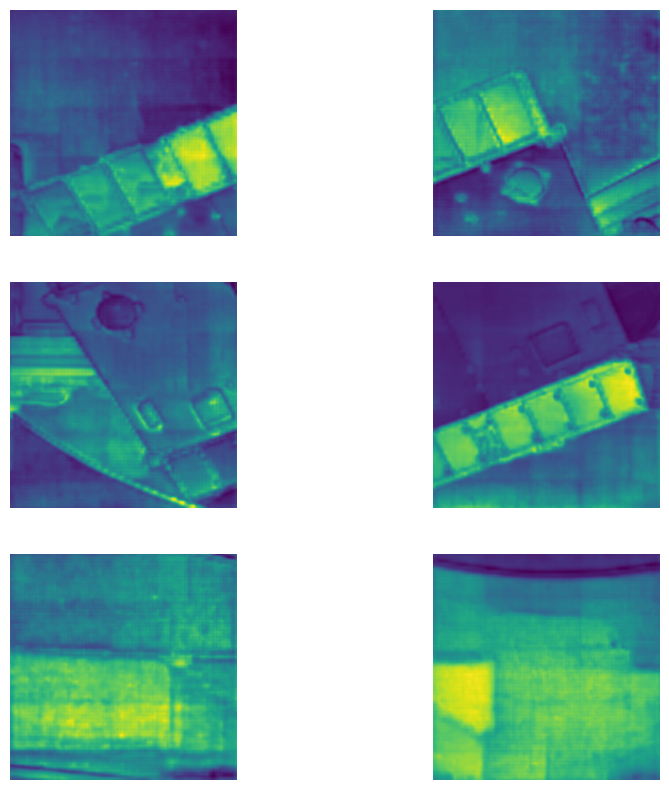

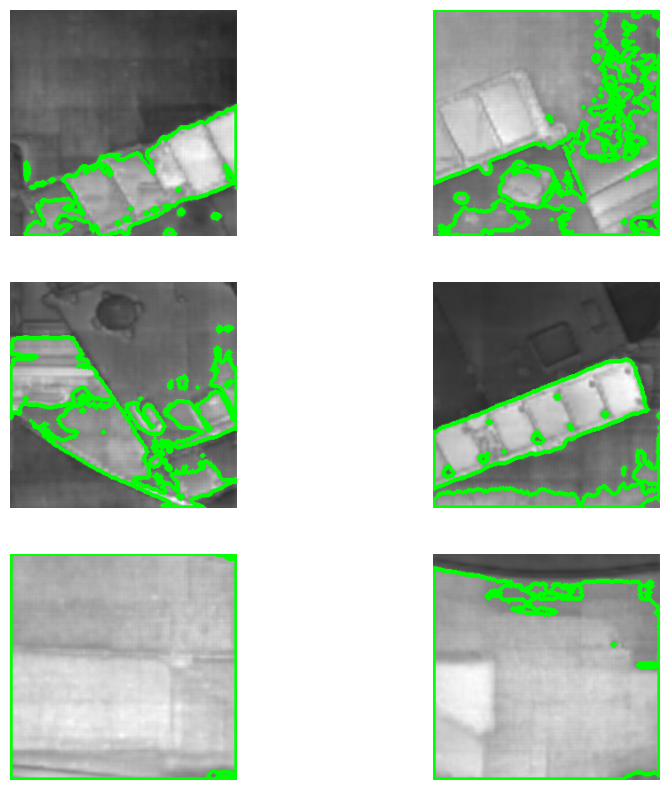

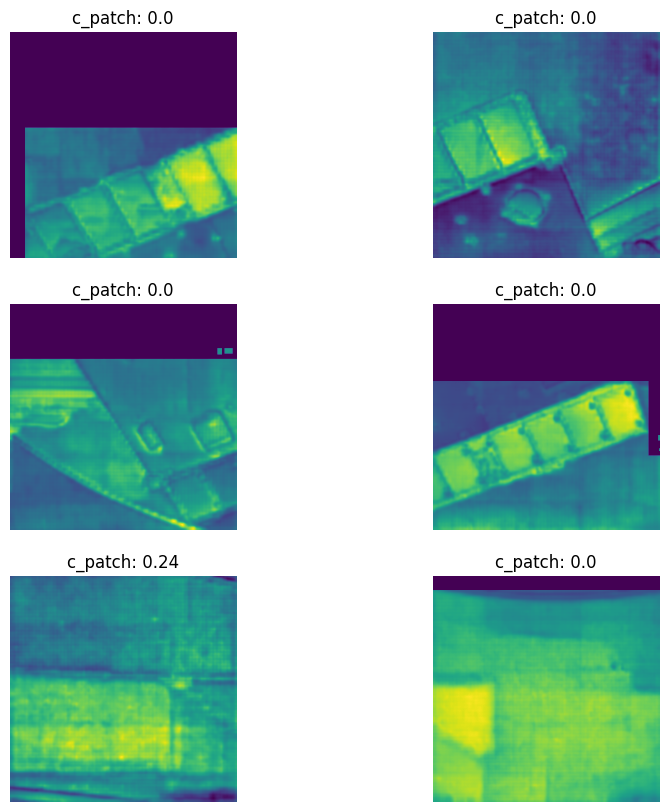

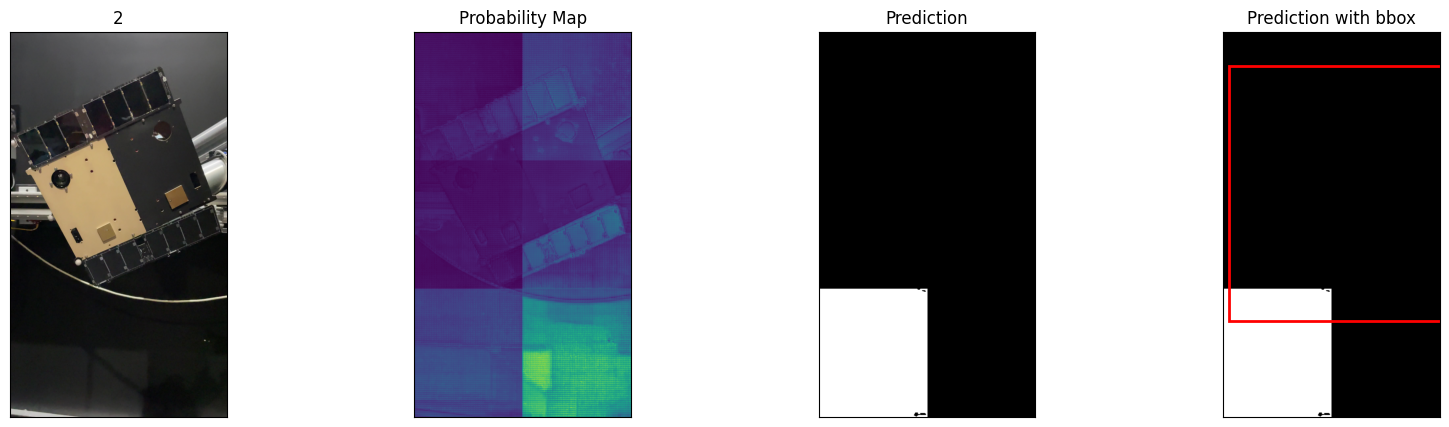

In [32]:
mask_pred, mask_prob = sample_prediction(model_loaded, processor, get_device(), test_dataset, new_dims, thresh=0.5, idx=2, verbose=True, iou_or_bbox='iou')